# 🔍 Detecting Political Affiliation and Thematic Trends in Reddit Discourse
This notebook covers data collection, classification, and topic modeling using Reddit data from r/Democrats and r/Republicans.

In [ ]:
#Installation Setup

!pip install praw
!pip install spacy vaderSentiment bertopic wordcloud textstat --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# 📚 Imports and Setup

# General-purpose libraries
import warnings
import logging
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reddit API
import praw

# Suppress warnings and PRAW logs
warnings.filterwarnings("ignore", category=UserWarning, module="praw")
logging.getLogger("praw").setLevel(logging.ERROR)

# NLP & Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from textstat import flesch_reading_ease
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
from bertopic import BERTopic

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

# Traditional ML
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

# Transformers & Deep Learning
import torch
from torch.utils.data import Dataset
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    BartTokenizer,
    BartForSequenceClassification,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# 🔐 Reddit API Authentication
reddit = praw.Reddit(
    client_id="J_AsaAXgfnC9i6qmdoopYQ",
    client_secret="wiRiW0_9LU3M3SQ710vcEMrZZkmbJA",
    user_agent="DataScienceScraper by AdPutrid8574"
)

In [ ]:
# 📥 Fetch Reddit Posts
def fetch_posts(subreddit_name, limit=1000):
    subreddit = reddit.subreddit(subreddit_name)
    posts = []
    for post in subreddit.top(limit=limit):
        posts.append(post.title + ' ' + post.selftext)
    return posts


dem_posts = fetch_posts('Democrats', 1000)
rep_posts = fetch_posts('Republicans', 1000)

df = pd.DataFrame({
    'text': dem_posts + rep_posts,
    'label': ['Democrat'] * len(dem_posts) + ['Republican'] * len(rep_posts)
})
df.dropna(inplace=True)

In [ ]:
# Save DataFrame to CSV
df.to_csv("reddit_political_posts.csv", index=False)

In [ ]:
df.head()

,text,label
0,This is President Barack Obama. He did not sel...,Democrat
1,My respect for Al Green just went up ⬆️,Democrat
2,This is the correct response to Trump’s reacti...,Democrat
3,My one and only response to this event. Don’t ...,Democrat
4,Does anyone else think a daily briefing would ...,Democrat


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1989 non-null   object
 1   label   1989 non-null   object
dtypes: object(2)
memory usage: 31.2+ KB


In [ ]:
print("Total posts:", len(df))
print("Democrat posts:", sum(df['label'] == 'Democrat'))
print("Republican posts:", sum(df['label'] == 'Republican'))


Total posts: 1989
Democrat posts: 991
Republican posts: 998


<Axes: title={'center': 'Label Distribution'}, xlabel='label'>

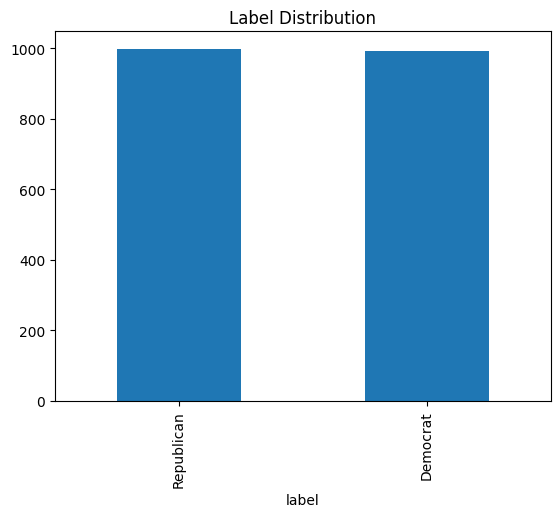

In [ ]:
df['label'].value_counts().plot(kind='bar', title='Label Distribution')


In [ ]:
# Show a random Democrat post
print("🟦 Democrat Sample:\n", df[df['label'] == 'Democrat']['text'].sample(1).values[0])

# Show a random Republican post
print("\n🟥 Republican Sample:\n", df[df['label'] == 'Republican']['text'].sample(1).values[0])


🟦 Democrat Sample:
 Trump is ‘furious’ with New York Gov. Cuomo because his pandemic press conferences are overshadowing him 

🟥 Republican Sample:
 But Adam did it . 


In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    tokens = text.split()  # ✅ Simple tokenization without punkt
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess)

In [ ]:
# Save DataFrame to CSV
df.to_csv("reddit_political_posts_cleaned.csv", index=False)

In [ ]:
# Step 1: Label encode and split
df['label_int'] = df['label'].map({'Democrat': 0, 'Republican': 1})
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label_int'], random_state=42)

# Step 2: Build pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, stop_words='english')),
    ('logreg', LogisticRegression(max_iter=1000))
])

# Step 3: Define more regularized param grid
param_grid = {
    'tfidf__max_features': [5000, 8000],
    'tfidf__ngram_range': [(1, 2)],
    'tfidf__min_df': [5],
    'tfidf__max_df': [0.7, 0.8],
    'logreg__C': [0.002, 0.003, 0.005],
    'logreg__penalty': ['l2'],
    'logreg__solver': ['saga'],
    'logreg__class_weight': ['balanced', None]
}

# Step 4: Grid Search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
grid.fit(train_df['clean_text'], train_df['label_int'])

# Step 5: Evaluate best model
best_model = grid.best_estimator_
print("\n✅ Best Hyperparameters:")
print(grid.best_params_)

X_train = train_df['clean_text']
y_train = train_df['label_int']
X_val = val_df['clean_text']
y_val = val_df['label_int']

train_preds = best_model.predict(X_train)
val_preds = best_model.predict(X_val)
train_proba = best_model.predict_proba(X_train)
val_proba = best_model.predict_proba(X_val)

logreg_metrics = {
    "Training": {
        "Accuracy": accuracy_score(y_train, train_preds),
        "Precision": precision_score(y_train, train_preds),
        "Recall": recall_score(y_train, train_preds),
        "F1": f1_score(y_train, train_preds),
        "Log Loss": log_loss(y_train, train_proba)
    },
    "Validation": {
        "Accuracy": accuracy_score(y_val, val_preds),
        "Precision": precision_score(y_val, val_preds),
        "Recall": recall_score(y_val, val_preds),
        "F1": f1_score(y_val, val_preds),
        "Log Loss": log_loss(y_val, val_proba)
    }
}

results_df = pd.DataFrame(logreg_metrics).T.round(4)
print("\n📊 Logistic Regression:")
print(results_df)


Fitting 5 folds for each of 24 candidates, totalling 120 fits

✅ Best Hyperparameters:
{'logreg__C': 0.005, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'logreg__solver': 'saga', 'tfidf__max_df': 0.7, 'tfidf__max_features': 5000, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}

📊 Logistic Regression:
            Accuracy  Precision  Recall      F1  Log Loss
Training      0.6675     0.6127   0.916  0.7343    0.6902
Validation    0.6231     0.5822   0.885  0.7024    0.6913


In [ ]:
# Step 1: Build pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, stop_words='english')),
    ('svm', CalibratedClassifierCV(estimator=SVC()))
])

# Step 2: Define more regularized param grid
param_grid = {
    'tfidf__max_features': [2000, 3000],
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [7, 10],
    'tfidf__max_df': [0.6, 0.7],
    'svm__estimator__C': [0.001, 0.005, 0.01],
    'svm__estimator__kernel': ['linear'],
    'svm__estimator__class_weight': ['balanced']
}

# Step 3: Grid Search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
grid.fit(train_df['clean_text'], train_df['label_int'])

# Step 4: Evaluate best model
best_svm = grid.best_estimator_
print("\n✅ Best Hyperparameters:")
print(grid.best_params_)

X_train = train_df['clean_text']
y_train = train_df['label_int']
X_val = val_df['clean_text']
y_val = val_df['label_int']

train_preds = best_svm.predict(X_train)
val_preds = best_svm.predict(X_val)
train_proba = best_svm.predict_proba(X_train)
val_proba = best_svm.predict_proba(X_val)

svm_metrics = {
    "Training": {
        "Accuracy": accuracy_score(y_train, train_preds),
        "Precision": precision_score(y_train, train_preds),
        "Recall": recall_score(y_train, train_preds),
        "F1": f1_score(y_train, train_preds),
        "Log Loss": log_loss(y_train, train_proba)
    },
    "Validation": {
        "Accuracy": accuracy_score(y_val, val_preds),
        "Precision": precision_score(y_val, val_preds),
        "Recall": recall_score(y_val, val_preds),
        "F1": f1_score(y_val, val_preds),
        "Log Loss": log_loss(y_val, val_proba)
    }
}

results_df = pd.DataFrame(svm_metrics).T.round(4)
print("\n📊 SVM Performance:")
print(results_df)


Fitting 5 folds for each of 24 candidates, totalling 120 fits

✅ Best Hyperparameters:
{'svm__estimator__C': 0.001, 'svm__estimator__class_weight': 'balanced', 'svm__estimator__kernel': 'linear', 'tfidf__max_df': 0.6, 'tfidf__max_features': 2000, 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 1)}

📊 SVM Performance:
            Accuracy  Precision  Recall      F1  Log Loss
Training      0.6631     0.6403  0.7494  0.6905    0.6363
Validation    0.6482     0.6200  0.7750  0.6889    0.6514


In [ ]:
# Step 1: Build pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(sublinear_tf=True, stop_words='english')),
    ('rf', RandomForestClassifier(random_state=42))
])

# Step 2: Define refined param grid for better generalization
param_grid = {
    'tfidf__max_features': [1000],
    'tfidf__ngram_range': [(1, 1)],
    'tfidf__min_df': [10],
    'tfidf__max_df': [0.6],
    'rf__n_estimators': [100],
    'rf__max_depth': [4],
    'rf__min_samples_split': [20],
    'rf__class_weight': ['balanced']
}

# Step 3: GridSearchCV setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='f1', verbose=1, n_jobs=-1)
grid.fit(train_df['clean_text'], train_df['label_int'])

# Step 4: Best model
best_rf = grid.best_estimator_
print("\n✅ Best Hyperparameters:")
print(grid.best_params_)

X_train = train_df['clean_text']
y_train = train_df['label_int']
X_val = val_df['clean_text']
y_val = val_df['label_int']

train_preds = best_rf.predict(X_train)
val_preds = best_rf.predict(X_val)
train_proba = best_rf.predict_proba(X_train)
val_proba = best_rf.predict_proba(X_val)

rf_metrics = {
    "Training": {
        "Accuracy": accuracy_score(y_train, train_preds),
        "Precision": precision_score(y_train, train_preds),
        "Recall": recall_score(y_train, train_preds),
        "F1": f1_score(y_train, train_preds),
        "Log Loss": log_loss(y_train, train_proba)
    },
    "Validation": {
        "Accuracy": accuracy_score(y_val, val_preds),
        "Precision": precision_score(y_val, val_preds),
        "Recall": recall_score(y_val, val_preds),
        "F1": f1_score(y_val, val_preds),
        "Log Loss": log_loss(y_val, val_proba)
    }
}


results_df = pd.DataFrame(rf_metrics).T.round(4)
print("\n📊 Random Forest Performance (Generalization Improved):")
print(results_df)


Fitting 5 folds for each of 1 candidates, totalling 5 fits

✅ Best Hyperparameters:
{'rf__class_weight': 'balanced', 'rf__max_depth': 4, 'rf__min_samples_split': 20, 'rf__n_estimators': 100, 'tfidf__max_df': 0.6, 'tfidf__max_features': 1000, 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 1)}

📊 Random Forest Performance (Generalization Improved):
            Accuracy  Precision  Recall      F1  Log Loss
Training      0.6644     0.6148   0.886  0.7259    0.6596
Validation    0.6332     0.5931   0.860  0.7020    0.6701


In [ ]:
# Reproducibility
set_seed = lambda seed=42: (torch.manual_seed(seed), torch.cuda.manual_seed_all(seed))
set_seed(42)

# Load Tokenizer & Model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

for module in model.modules():
    if isinstance(module, torch.nn.Dropout):
        module.p = 0.5  # increase dropout to regularize

# Dataset Class
class PoliticalTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx] if isinstance(self.texts, pd.Series) else self.texts[idx]
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        label = int(self.labels.iloc[idx] if isinstance(self.labels, pd.Series) else self.labels[idx])
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create Datasets
train_dataset = PoliticalTextDataset(train_df['clean_text'], train_df['label_int'], tokenizer)
val_dataset = PoliticalTextDataset(val_df['clean_text'], val_df['label_int'], tokenizer)

# Training Arguments (Updated for Regularization)
training_args = TrainingArguments(
    output_dir="./distilbert_results",
    num_train_epochs=6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=3e-5,
    weight_decay=0.3,
    warmup_steps=100,
    lr_scheduler_type="linear",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_strategy="epoch",
    logging_first_step=True,
    report_to="none",
    fp16=torch.cuda.is_available()
)

# Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train and Evaluate
print("🚀 Training DistilBERT with Better Generalization...")
trainer.train()
bert_metrics = trainer.evaluate(val_dataset)

# Print Metrics
print("\n📊 Final DistilBERT Validation Metrics:")
for key, value in bert_metrics.items():
    print(f"{key}: {value:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Training DistilBERT with Better Generalization...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.682700,0.653975,0.650754,0.664865,0.615000,0.638961
2,0.651400,0.646397,0.638191,0.668675,0.555000,0.606557
3,0.626900,0.625639,0.660804,0.647059,0.715000,0.679335
4,0.600200,0.631594,0.658291,0.664948,0.645000,0.654822
5,0.557500,0.643729,0.655779,0.668449,0.625000,0.645995



📊 Final DistilBERT Validation Metrics:
eval_loss: 0.6256
eval_accuracy: 0.6608
eval_precision: 0.6471
eval_recall: 0.7150
eval_f1: 0.6793
eval_runtime: 0.6462
eval_samples_per_second: 615.8930
eval_steps_per_second: 77.3740
epoch: 5.0000


In [ ]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Set random seed
set_seed = lambda seed=42: (torch.manual_seed(seed), torch.cuda.manual_seed_all(seed))
set_seed(42)

# Load tokenizer and model
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
model = BartForSequenceClassification.from_pretrained('facebook/bart-base', num_labels=2)

# Increase dropout for generalization
for module in model.modules():
    if isinstance(module, torch.nn.Dropout):
        module.p = 0.3

# Dataset class
class PoliticalTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx] if isinstance(self.texts, pd.Series) else self.texts[idx]
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        label = int(self.labels.iloc[idx] if isinstance(self.labels, pd.Series) else self.labels[idx])
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Build datasets
train_dataset = PoliticalTextDataset(train_df['clean_text'], train_df['label_int'], tokenizer)
val_dataset = PoliticalTextDataset(val_df['clean_text'], val_df['label_int'], tokenizer)

# Training arguments (optimized for generalization)
training_args = TrainingArguments(
    output_dir="./bart_generalized",
    num_train_epochs=6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.3,
    warmup_steps=100,
    lr_scheduler_type="linear",
    gradient_accumulation_steps=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_strategy="epoch",
    logging_first_step=True,
    report_to="none",
    disable_tqdm=False,
    fp16=torch.cuda.is_available()
)

# Metric calculation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, tuple):
        logits = logits[0]
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

# Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("🚀 Training BART with Generalization Enhancements...")
trainer.train()
bart_metrics = trainer.evaluate(val_dataset)

# Final Metrics
print("\n📊 Generalized BART Validation Metrics:")
for key, value in bart_metrics.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Some weights of BartForSequenceClassification were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Training BART with Generalization Enhancements...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.709200,0.656807,0.625628,0.633508,0.605000,0.618926
2,0.661400,0.700919,0.585427,0.705882,0.300000,0.421053
3,0.634400,0.641050,0.645729,0.680982,0.555000,0.611570
4,0.595100,0.646654,0.665829,0.693642,0.600000,0.643432
5,0.544100,0.678480,0.650754,0.713287,0.510000,0.594752


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight'].



📊 Generalized BART Validation Metrics:
eval_loss: 0.6410
eval_accuracy: 0.6457
eval_precision: 0.6810
eval_recall: 0.5550
eval_f1: 0.6116
eval_runtime: 1.4889
eval_samples_per_second: 267.3080
eval_steps_per_second: 33.5810
epoch: 5.0000


In [ ]:
warnings.filterwarnings("ignore")

# Set random seed
set_seed = lambda seed=42: (torch.manual_seed(seed), torch.cuda.manual_seed_all(seed))
set_seed(42)

# Load model and tokenizer
MODEL = "cardiffnlp/twitter-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2)

# Dataset
class PoliticalDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Prepare datasets
train_dataset = PoliticalDataset(train_df['clean_text'], train_df['label_int'], tokenizer)
val_dataset = PoliticalDataset(val_df['clean_text'], val_df['label_int'], tokenizer)

# Training args with improved generalization settings
training_args = TrainingArguments(
    output_dir="./twitter_roberta_gen_results",
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=1.5e-5,
    weight_decay=0.2,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    gradient_accumulation_steps=2,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    logging_strategy="epoch",
    disable_tqdm=False,
    logging_first_step=True,
    report_to="none",
    fp16=torch.cuda.is_available()
)

# Evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train and Evaluate
print("🚀 Training Twitter RoBERTa (Generalization Improved)...")
trainer.train()
roberta_metrics = trainer.evaluate(val_dataset)

# Results
print("\n📊 Final Twitter RoBERTa Validation Metrics:")
for k, v in roberta_metrics.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Training Twitter RoBERTa (Generalization Improved)...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.684000,0.656293,0.603015,0.584000,0.730000,0.648889
2,0.620400,0.634187,0.650754,0.644550,0.680000,0.661800
3,0.418000,0.710540,0.648241,0.635135,0.705000,0.668246



📊 Final Twitter RoBERTa Validation Metrics:
eval_loss: 0.6342
eval_accuracy: 0.6508
eval_precision: 0.6445
eval_recall: 0.6800
eval_f1: 0.6618
eval_runtime: 0.9031
eval_samples_per_second: 440.7260
eval_steps_per_second: 55.3680
epoch: 3.9648


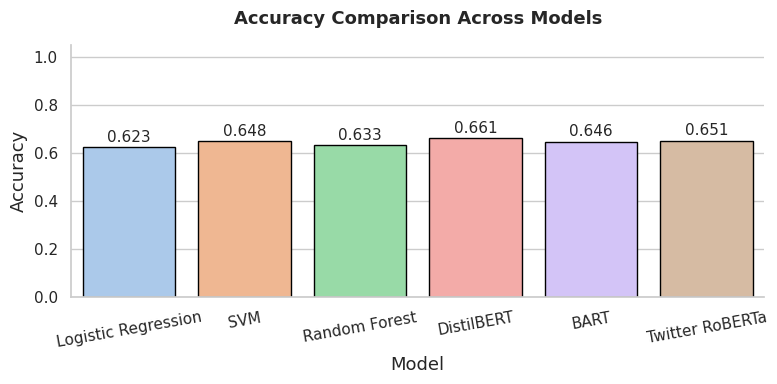

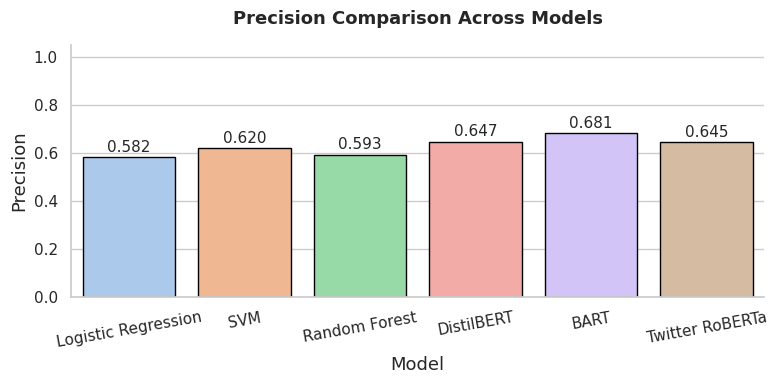

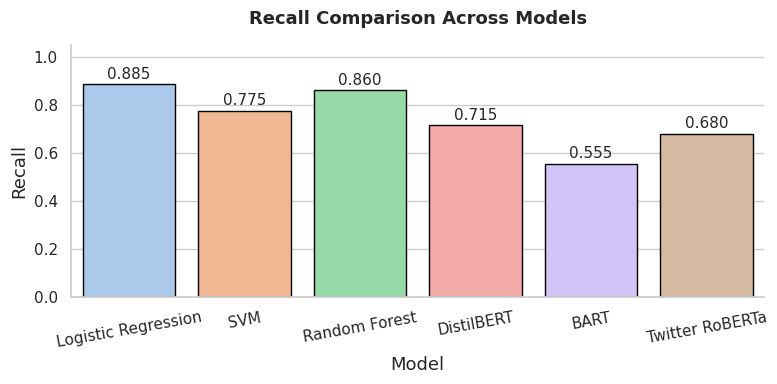

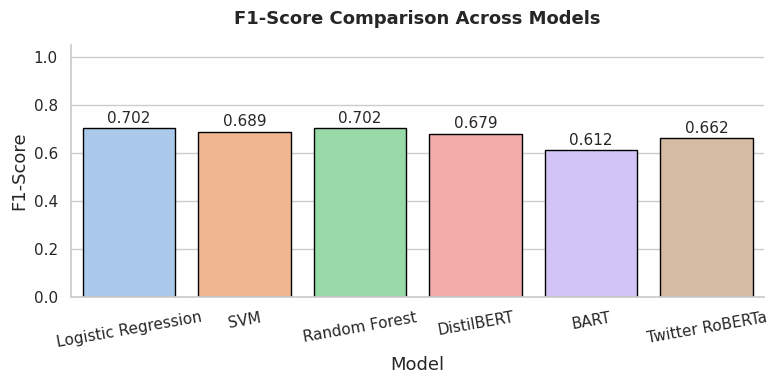

In [ ]:
# Model names
model_names = [
    "Logistic Regression",
    "SVM",
    "Random Forest",
    "DistilBERT",
    "BART",
    "Twitter RoBERTa"
]

# Metric values
accuracies = [
    logreg_metrics["Validation"]["Accuracy"],
    svm_metrics["Validation"]["Accuracy"],
    rf_metrics["Validation"]["Accuracy"],
    bert_metrics["eval_accuracy"],
    bart_metrics["eval_accuracy"],
    roberta_metrics["eval_accuracy"]
]

precisions = [
    logreg_metrics["Validation"]["Precision"],
    svm_metrics["Validation"]["Precision"],
    rf_metrics["Validation"]["Precision"],
    bert_metrics["eval_precision"],
    bart_metrics["eval_precision"],
    roberta_metrics["eval_precision"]
]

recalls = [
    logreg_metrics["Validation"]["Recall"],
    svm_metrics["Validation"]["Recall"],
    rf_metrics["Validation"]["Recall"],
    bert_metrics["eval_recall"],
    bart_metrics["eval_recall"],
    roberta_metrics["eval_recall"]
]

f1_scores = [
    logreg_metrics["Validation"]["F1"],
    svm_metrics["Validation"]["F1"],
    rf_metrics["Validation"]["F1"],
    bert_metrics["eval_f1"],
    bart_metrics["eval_f1"],
    roberta_metrics["eval_f1"]
]

sns.set_theme(style="whitegrid")
custom_palette = sns.color_palette("pastel")

def plot_metric(values, metric_name):
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(x=model_names, y=values, palette=custom_palette, edgecolor="black")

    for i, v in enumerate(values):
        ax.text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=11)

    ax.set_title(f"{metric_name} Comparison Across Models", fontsize=13, weight='bold', pad=15)
    ax.set_xlabel("Model", fontsize=13)
    ax.set_ylabel(metric_name, fontsize=13)
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='x', rotation=10)
    sns.despine()
    plt.tight_layout()
    plt.show()

plot_metric(accuracies, "Accuracy")
plot_metric(precisions, "Precision")
plot_metric(recalls, "Recall")
plot_metric(f1_scores, "F1-Score")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



📊 Linguistic Feature Comparison by Subreddit:
            lexical_richness  pronoun_ratio  flesch_score  sentiment
label                                                               
Democrat              0.7823         0.0815       65.1408     0.0301
Republican            0.8062         0.0708       66.3988     0.0021


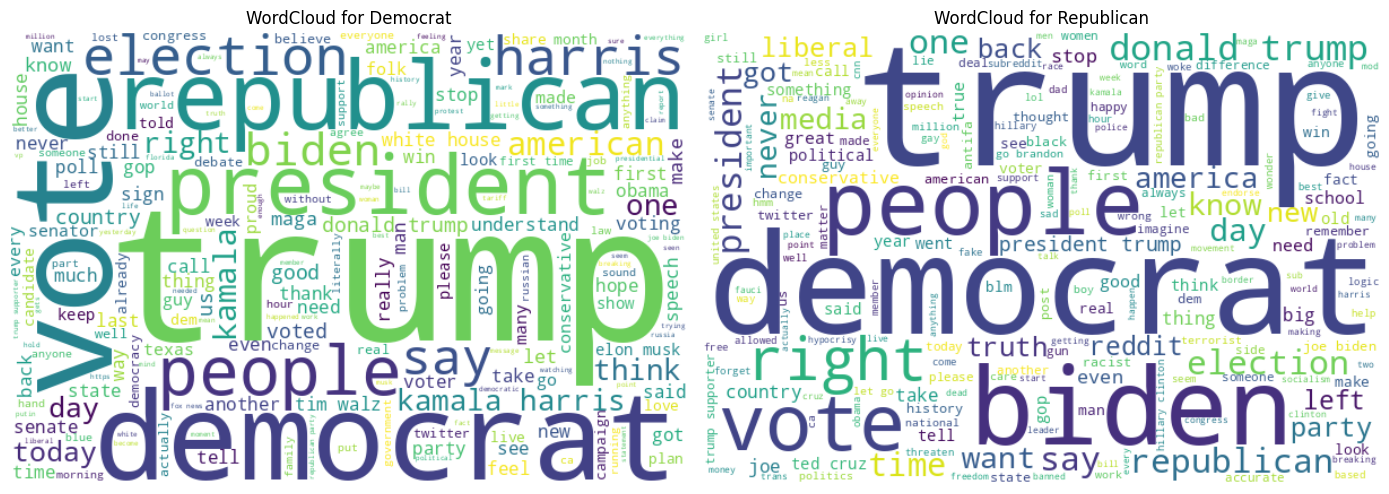

In [ ]:
# 🧠 spaCy setup
stop_words = set(stopwords.words("english"))
nlp = spacy.load("en_core_web_sm")
analyzer = SentimentIntensityAnalyzer()

# Clean Text
def clean_text(text):
    words = nltk.word_tokenize(text)
    return ' '.join([w.lower() for w in words if w.isalpha() and w.lower() not in stop_words])

df['clean_text'] = df['text'].apply(clean_text)

# Linguistic Features Function
def get_linguistic_features(text):
    doc = nlp(text)
    total = len(doc)
    unique = len(set([token.text.lower() for token in doc if token.is_alpha]))
    pronouns = sum(1 for token in doc if token.pos_ == 'PRON')
    return {
        'lexical_richness': unique / total if total > 0 else 0,
        'pronoun_ratio': pronouns / total if total > 0 else 0,
        'flesch_score': flesch_reading_ease(text)
    }

# Apply Linguistic Analysis
ling_features = df['text'].apply(get_linguistic_features).apply(pd.Series)
df = df.drop(columns=['lexical_richness', 'pronoun_ratio', 'flesch_score'], errors='ignore')  # avoid duplicates
df = pd.concat([df, ling_features], axis=1)

# Sentiment Analysis
df['sentiment'] = df['text'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# Clean Linguistic Summary
linguistic_summary = df.groupby('label')[['lexical_richness', 'pronoun_ratio', 'flesch_score', 'sentiment']].mean().round(4)

print("\n📊 Linguistic Feature Comparison by Subreddit:")
print(linguistic_summary)

#  WordCloud
plt.figure(figsize=(14, 6))
for i, label in enumerate(df['label'].unique()):
    text = " ".join(df[df['label'] == label]['clean_text'])
    wc = WordCloud(width=600, height=400, background_color='white').generate(text)
    plt.subplot(1, 2, i+1)
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f"WordCloud for {label}")
    plt.axis("off")
plt.tight_layout()
plt.show()
